# Reduced DDM prediction of BOLD dynamics

DDM-based predictions of the visual cortex BOLD dynamics. Mostly same with Figs.6d-f.

In [1]:
import os
import sys
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

sys.path.append('..')
from src import utils
utils.setup_matplotlib()

In [2]:
utils.download_dataset("data/outputs/behavior")
utils.download_dataset("data/outputs/ddm")

with open('../data/outputs/behavior/results_stimulus_specific_bias.pickle', 'rb') as f:
    ssb = pickle.load(f)
    
with open('../data/outputs/ddm/bootstrap_ddm_stimulus_conditioned.pickle', 'rb') as f:
    stim_cond = pickle.load(f)
    
with open('../data/outputs/ddm/bootstrap_ddm_decision_conditioned.pickle', 'rb') as f:
    decision_cond = pickle.load(f)

downloading data/outputs/behavior...
data/outputs/behavior already exists. Skipping download...
downloading data/outputs/ddm...
data/outputs/ddm already exists. Skipping download...


In [3]:
from src.model_ddm import model
sys.modules['model'] = model
model_path = '../models/ddm/'

In [4]:
models_full = {}
models_rdcd = {}

# full model
files  = sorted([f for f in os.listdir(model_path+'full') if ('.pkl' in f)])
for v_f in files:
    with open(model_path+'full/'+v_f, 'rb') as f:
        models_full[v_f[17:21]] = pickle.load(f)
    
# reduced model
files  = sorted([f for f in os.listdir(model_path+'reduced') if ('.pkl' in f)])
for v_f in files:
    with open(model_path+'reduced/'+v_f, 'rb') as f:
        models_rdcd[v_f[17:21]] = pickle.load(f)

---
## Stimulus-specific bias dynamics

In [5]:
stims = np.arange(180,step=7.5)
ssb_popm = utils.circmean(stim_cond['pop'],axis=0)
ssb_pope = utils.wrap(stim_cond['pop'] - stims.reshape((1,1,1,1,-1)), period=180.)
ssb_pops = np.std(ssb_pope, axis=0)

In [6]:
for i_delay in range(2):
    ssb_popm[1,:,i_delay,12][ssb_popm[1,:,i_delay,12]>0] -= 180

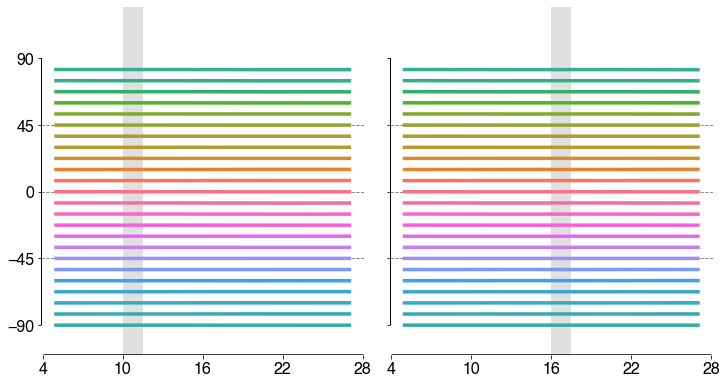

In [7]:
i_models = 1
f, ax = plt.subplots(1,2,sharey=True)
utils.set_size([8,4.2])

ax[0].axvspan(10,11.5,color='darkgrey',alpha=0.35,linewidth=0,zorder=-3)
ax[1].axvspan(16,17.5,color='darkgrey',alpha=0.35,linewidth=0,zorder=-3)

for i_fig in range(2):
    for s in range(24):
        ax[i_fig].fill_between(np.arange(3,15)*2-1, 
                         ssb_popm[i_models,:,i_fig,s]-ssb_pops[i_models,:,i_fig,s], 
                         ssb_popm[i_models,:,i_fig,s]+ssb_pops[i_models,:,i_fig,s], 
                         color=utils.HUSL.colors[s], alpha=0.5, linewidth=0)
        ax[i_fig].plot(np.arange(3,15)*2-1, ssb_popm[i_models,:,i_fig,s], color=utils.HUSL.colors[s], linewidth=3.5)
        
    ax[i_fig].set_ylim([-125+15,125])
    ax[i_fig].axhline(y=0,   color='gray', linestyle='dashed', linewidth=0.9, zorder=0)
    ax[i_fig].axhline(y=45,  color='gray', linestyle='dashed', linewidth=0.9, zorder=0)
    ax[i_fig].axhline(y=-45, color='gray', linestyle='dashed', linewidth=0.9, zorder=0)
    utils.draw_publish_axis(ax[i_fig], xrange=(4,28), yrange=(-90,90), xticks=[4,10,16,22,28], yticks=[-90,-45,0,45,90])    

if utils.LABEL:
    ax[0].set_ylabel(r"Orientation in memory $(\!\!^\circ\!\!)$", labelpad=0)
    
plt.savefig(f'{utils.DIR_FIGURE}/sfig7a.pdf',bbox_inches='tight')
plt.show()    

In [8]:
ssb_idvm  = utils.circmean(stim_cond['indiv'],axis=0)
ssb_idvme = utils.wrap(ssb_idvm-stims.reshape((1,1,1,-1,1)), period=180.)

In [9]:
ssb_sim = np.nan*np.zeros((2,12,50,2))

for i_models, (k_models, models) in enumerate({'full': models_full, 'reduced': models_rdcd}.items()):
    for i_m, (k_m, model) in enumerate(models.items()):
        _ssb = utils.stimulus_specific_bias(stims, ssb['weights'][int(k_m)], **ssb['info'])
        for i_t, v_t in enumerate([1,2]):
            for i_tr in range(12):
                pattn = ssb_idvme[i_models,i_tr,i_t,:,i_m]
                reg = LinearRegression(fit_intercept=False).fit(_ssb.reshape(-1,1),pattn)
                ssb_sim[i_models,i_tr,i_m,i_t] = reg.coef_[0]

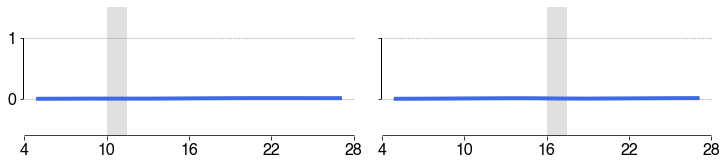

In [10]:
i_models = 1

f, ax = plt.subplots(1,2, sharey=True)
utils.set_size([8,1.9])
ax[0].axvspan(10,11.5,color='darkgrey',alpha=0.35,linewidth=0,zorder=-3)
ax[1].axvspan(16,17.5,color='darkgrey',alpha=0.35,linewidth=0,zorder=-3)

for i_fig in range(2):
    mmm = np.nanmean(ssb_sim[i_models,:,:,i_fig],axis=1)
    sss = np.nanstd(ssb_sim[i_models,:,:,i_fig],axis=1)/np.sqrt(50)
    ax[i_fig].axhline(y=0, color='gray', linestyle='dashed', linewidth=0.5)
    ax[i_fig].axhline(y=1, color='gray', linestyle='dashed', linewidth=0.5)
    ax[i_fig].plot(np.arange(3,15)*2-1, mmm, linewidth=4, color='#4169e1')
    ax[i_fig].fill_between(np.arange(3,15)*2-1, mmm-sss, mmm+sss, alpha=0.3, linewidth=0, color='#4169e1')
    ax[i_fig].set_ylim([-0.6,1.5])
    utils.draw_publish_axis(ax[i_fig], xrange=(4,28), yrange=(0,1), xticks=[4,10,16,22,28], yticks=[0,1])

if utils.LABEL:
    ax[0].set_xlabel(r"Time from trial onset (s)")
    ax[1].set_xlabel(r"Time from trial onset (s)")
    ax[0].set_ylabel(r"Bias weight", labelpad=8)

plt.savefig(f'{utils.DIR_FIGURE}/sfig7b.pdf',bbox_inches='tight')
plt.show()

---
## Decision-consistent bias dynamics

In [11]:
trs  = np.arange(3,15)*2-1
dmIs = [12,24]
convms = np.std(decision_cond['convm'],axis=0)
convmm = utils.circmean(decision_cond['convm'],axis=0)
convmm = np.stack([-convmm,+convmm],axis=-1)
mm = utils.circmean(decision_cond['m'],axis=0)
mm = np.stack([-mm,+mm],axis=-1)

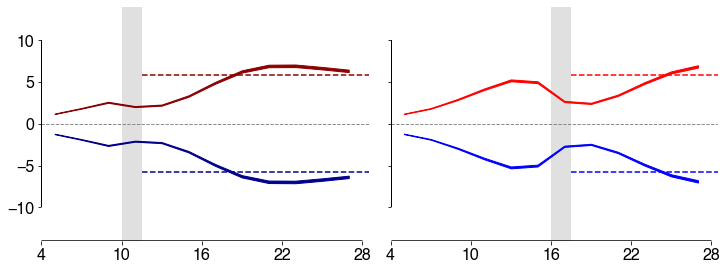

In [12]:
i_models = 1
f, ax = plt.subplots(1,2, sharey=True)
utils.set_size([8,3])

colse = ['darkblue', 'darkred']
colsl = ['blue', 'red']

ax[0].axvspan(10,11.5,color='darkgrey',alpha=0.35,linewidth=0,zorder=-3)
ax[1].axvspan(16,17.5,color='darkgrey',alpha=0.35,linewidth=0,zorder=-3)

for i_delay, delay in enumerate([1,2]):
    ax[i_delay].axhline(y=0,   color='gray', linestyle='dashed', linewidth=0.9, zorder=0)
    cols = colse if i_delay==0 else colsl
    for i_dm in range(2):
        ax[i_delay].fill_between(trs, 
                                 convmm[i_models,:,i_delay,i_dm]-convms[i_models,:,i_delay], 
                                 convmm[i_models,:,i_delay,i_dm]+convms[i_models,:,i_delay], color=cols[i_dm])
    ax[i_delay].set_ylim([-14,14])
    ax[i_delay].set_xlim([4,28.5])
    utils.draw_publish_axis(ax[i_delay], xrange=(4,28), yrange=(-10,10), xticks=[4,10,16,22,28], yticks=[-10,-5,0,5,10])
    
ax[0].hlines(mm[i_models,dmIs[0]+1,0,1], 11.5, 28.5, color='darkred',  linestyle='dashed')
ax[0].hlines(mm[i_models,dmIs[0]+1,0,0], 11.5, 28.5, color='darkblue', linestyle='dashed')
ax[1].hlines(mm[i_models,dmIs[1]+1,0,1], 17.5, 28.5, color='red',  linestyle='dashed')
ax[1].hlines(mm[i_models,dmIs[1]+1,0,0], 17.5, 28.5, color='blue', linestyle='dashed')

if utils.LABEL:
    ax[0].set_xlabel(r"Time from trial onset (s)")    
    ax[1].set_xlabel(r"Time from trial onset (s)")    
    ax[0].set_ylabel(r"Memory error $(\!\!^\circ\!\!)$", labelpad=0)
        
plt.savefig(f'{utils.DIR_FIGURE}/sfig7c.pdf',bbox_inches='tight')
plt.show()